<a href="https://colab.research.google.com/github/abrarelidrisi/MRI-Segmentation/blob/main/3D_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Task 3: 3D MRI Segmentation:**

In [1]:
#Importing important libraries and loading our dataset (containing of MRI scans and the ground truth (Segmented)images

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.io import loadmat
import sys
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects, remove_small_holes, binary_dilation
from scipy.ndimage import binary_dilation, binary_fill_holes
from skimage.feature import canny
import scipy.ndimage as ndi
from sklearn.cluster import KMeans
from skimage.filters import threshold_multiotsu
from scipy.ndimage import gaussian_filter

In [2]:
#Since I'll be using edge detection algorithms like Canny later on, It's better to normalize our data so the algorithms can perform better and not put muc count to outliers
def normalizing(T1):
  slice_normalized = (T1 - np.min(T1)) / (np.max(T1) - np.min(T1))
  return slice_normalized


In [3]:
# #We now start the segmentation process, beginning with smotthing using Gaussian filter
def smoothing(slice_normalized, sigma = 1):
  slice_smoothed = gaussian_filter(slice_normalized, sigma=sigma)
  return slice_smoothed

In [4]:
#Applying the advanced algorithm of Multi level Otsu Thresholding to better handle 3D mri images.
def otsu_thresholding(slice_smoothed):

    # Compute multi-Otsu thresholds
    thresholds = threshold_multiotsu(slice_smoothed)

    # Digitize the image into discrete regions
    thresholded = np.digitize(slice_smoothed, bins=thresholds)

    return thresholded

In [5]:
# Showcasing the outcome of applying otsu on our smoothed slice
def showcase_thresholded(thresholded, slice_smoothed):
  thresholded_img = thresholded * slice_smoothed

  return thresholded_img

In [6]:
#We apply canny edge detection. Given the nature of our ground truth, morphological processes such as hole filling and remove small objects has managed to achieve an improved accuracy
def applying_canny(thresholded_img, sigma=2, min_size=100):

    # Create an empty array to store edges
    edges = np.zeros_like(thresholded_img, dtype=bool)

    # Apply Canny slice by slice along the depth (3rd dimension)
    for i in range(thresholded_img.shape[2]):
        edges_ = canny(thresholded_img[:, :, i], sigma=sigma)  # Apply Canny on a 2D slice
        edges_ = binary_dilation(edges_)  # Dilate the edges
        edges_ = binary_fill_holes(edges_)  # Fill holes in the edges
        edges_ = remove_small_objects(edges_, min_size=min_size)  # Remove small objects
        edges[:, :, i] = edges_  # Store the processed edges

    return edges


In [7]:
#Showcasing the effect of applying Canny edge detection to our image
def showcasing_canny(slice_normalized, edges):

    # Multiply the original image by the edges to mask it
    img_thresholded = slice_normalized * edges  # Element-wise multiplication

    return img_thresholded

In [8]:
#Define k-means segmentation so we can apply it to the image
def kmeans_segmentation(image, n_clusters=6):
    # Reshape the image to a 2D array
    X = image.reshape(-1, 1)

    # Fit KMeans to the data
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)

    # Predict the labels for the data
    labels = kmeans.fit_predict(X)

    # Reshape the labels to the original image shape
    labels = labels.reshape(image.shape)

    # Get the centroids of the clusters
    centroids = kmeans.cluster_centers_

    # Order the centroids and return the indices
    order = np.argsort(centroids, axis=0)

    return labels, order

In [9]:
#Creating a temporal_mask dictionary so we can ensure efficient mapping. This step increaed the segmentation accuracy dramatically given that it allows us to use masks, where each mask is 1 and the rest is zero.  By combining them together, the noise is reduced.
def temporal_mask_creation(cluster_labels, order):
  temporal_masks = {}
  temporal_masks["0"] = (cluster_labels == order[0]).astype(int)
  temporal_masks["1"] = (cluster_labels == order[1]).astype(int)
  temporal_masks["2"] = (cluster_labels == order[2]).astype(int)
  temporal_masks["3"] = (cluster_labels == order[3]).astype(int)
  temporal_masks["4"] = (cluster_labels == order[4]).astype(int)
  temporal_masks["5"] = (cluster_labels == order[5]).astype(int)
  return temporal_masks

In [29]:
#Defining functions to help in plotting our masks, as well as cobining the masks to give our final segmented output
def plot_masks(temporal_masks, rows=1, cols=2, slice_id=None):

    fig, axes = plt.subplots(rows, cols, figsize=(12, 6))

    fig.suptitle('Temporal Masks')

    flatten_axes = axes.flat
    for ax, (key, mask) in zip(flatten_axes, temporal_masks.items()):
        # Check if the mask has more than 2 dimensions and slice it to 2D if needed
        if mask.ndim > 2:
            mask = mask[:, :, 0]  # Select the first slice of the 3D array

        if slice_id is not None:
            mask = mask[:, :, slice_id]
        ax.imshow(mask, cmap='gray')
        ax.set_title(f'Mask: {key}')
        ax.axis('off')

    plt.tight_layout()

def temporal_masks2final_segmented_mask(temporal_masks, labels=range(6), slice_id=None):
    if slice_id is not None:
        segmented_labels = np.zeros_like(temporal_masks["0"][:, :, 0])
    else:
        segmented_labels = np.zeros_like(temporal_masks["0"])

    # Accumulate all the temporal masks in the segmented_labels
    for label in labels:
        mask = temporal_masks[str(label)]
        if slice_id is not None:
            mask = mask[:, :, slice_id]
        segmented_labels[mask == 1] = label

    return segmented_labels

def temporal_masks2final_segmented_mask(temporal_masks, labels = range(6), slice_id = None):
    if slice_id is not None:
        segmented_labels = np.zeros_like(temporal_masks["0"][:,:,0])
    else:
        segmented_labels = np.zeros_like(temporal_masks["0"])

    # Accumulate all the temporal masks in the segmented_labels
    for label in labels:
        mask = temporal_masks[str(label)]
        if slice_id is not None:
            mask = mask[:,:,slice_id]
        segmented_labels[mask == 1] = label

    return segmented_labels

In [31]:
# Uncomment to showcase the masks
# plot_masks(temporal_masks, rows=2, cols=4)

In [12]:
#function to showcase our final segmented image
def showcase_segmented_image(temporal_masks):
  segmented_img = temporal_masks2final_segmented_mask(temporal_masks)

  return segmented_img

In [13]:
#Defining our Dice metrics
def dice_coefficient(pred, truth):
    pred = pred > 0  # Ensure binary format
    truth = truth > 0  # Ensure binary format
    intersection = np.sum(pred * truth)
    return 2 * intersection / (np.sum(pred) + np.sum(truth))

In [14]:
#Defining our Jaccard metrics
def jaccard_index(pred, truth):
    pred = pred > 0
    truth = truth > 0
    intersection = np.sum(pred * truth)
    union = np.sum(pred + truth) - intersection
    return intersection / union

In [15]:
#Defining our accuracy metrics
def pixel_accuracy(pred, truth):

    pred = pred > 0  # Ensure binary format
    truth = truth > 0  # Ensure binary format

    correct = np.sum(pred == truth)  # Count matching pixels
    total = truth.size  # Total number of pixels
    return correct / total

In [16]:
#Showcasing the performance of our segmentation algoirthm vs. the ground truth
def compare_label_distributions(ground_truth, prediction, num_classes):

    # Count label occurrences in ground truth
    gt_labels, gt_counts = np.unique(ground_truth, return_counts=True)
    gt_distribution = np.zeros(num_classes)
    gt_distribution[gt_labels] = gt_counts

    # Count label occurrences in prediction
    pred_labels, pred_counts = np.unique(prediction, return_counts=True)
    pred_distribution = np.zeros(num_classes)
    pred_distribution[pred_labels] = pred_counts

    # Normalize to percentage if needed
    gt_percentage = (gt_distribution / np.sum(gt_distribution)) * 100
    pred_percentage = (pred_distribution / np.sum(pred_distribution)) * 100

    # Plot the distributions
    labels = [f"Class {i}" for i in range(num_classes)]
    x = np.arange(num_classes)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - 0.2, gt_percentage, width=0.4, label='Ground Truth (%)', color='blue')
    ax.bar(x + 0.2, pred_percentage, width=0.4, label='Prediction (%)', color='orange')

    # Add labels, legend, and title
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_xlabel("Class Labels")
    ax.set_ylabel("Percentage of Pixels (%)")
    ax.set_title("Label Distribution: Ground Truth vs Prediction")
    ax.legend()

    plt.tight_layout()
    plt.show()

In [17]:
#Defining a segmentation function that applies the whole steps
def full_segmentation(slice):
    slice_data = T1
    ground_truth = label

    # List to store intermediate results and titles
    images = []
    titles = []
    colormaps = [] #To showcase the images

    # Step 1: Gaussian Normalizaing
    slice_normalized = normalizing(T1)
    images.append(slice_normalized[:, :, slice_normalized.shape[2] // 2])
    titles.append("Normalized Slice")
    colormaps.append("gray")

    # Step 2: Smoothing
    slice_smoothed = smoothing(slice_normalized)
    images.append(slice_smoothed[:, :, slice_smoothed.shape[2] // 2])
    titles.append("Gaussian Smoothed Slice")
    colormaps.append("gray")

    # Step 3: Otsu Thresholding
    thresholded = otsu_thresholding(slice_smoothed)
    thresholded_img = showcase_thresholded(thresholded, slice_smoothed)
    images.append(thresholded_img[:, :, thresholded_img.shape[2] // 2])
    titles.append("Otsu Thresholded Image")
    colormaps.append("grey")

    # Step 4: Apply Canny Edge Detection
    edges = applying_canny(thresholded_img)
    images.append(edges[:, :, edges.shape[2] // 2])
    titles.append("Canny Edges")
    colormaps.append("gray")

    # Step 5: Showcase Canny Effect
    img_thresholded = showcasing_canny(slice_normalized, edges)
    images.append(img_thresholded[:, :, img_thresholded.shape[2] // 2])
    titles.append("Masked Edges")
    colormaps.append(None)

    # Step 6: K-means Segmentation
    cluster_labels, order = kmeans_segmentation(thresholded_img, n_clusters=6)
    temporal_masks = temporal_mask_creation(cluster_labels, order)
    segmented_img = showcase_segmented_image(temporal_masks)
    images.append(segmented_img[:, :, segmented_img.shape[2] // 2])
    titles.append("Segmented Image")
    colormaps.append("viridis")

    # Showcase all results in a grid
    showcase_in_grid(images, titles, rows=2, cols=4, colormaps=colormaps)

    # Step 7: Compare Label Distributions (shown after the grid)
    compare_label_distributions(ground_truth, segmented_img, num_classes=6)

    # Step 7: Metrics
    dice_score = dice_coefficient(segmented_img, ground_truth)
    jaccard_score = jaccard_index(segmented_img, ground_truth)
    accuracy_score = pixel_accuracy(segmented_img, ground_truth)

    return temporal_masks, segmented_img, dice_score, jaccard_score, accuracy_score

In [18]:
#Plotting grid to showcase all results
def showcase_in_grid(images, titles, rows=2, cols=4, colormaps=None):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
    axes = axes.flatten()  # Flatten to index easily

    for i, (img, title) in enumerate(zip(images, titles)):
        if isinstance(img, np.ndarray):  # If it's an image
            cmap = colormaps[i] if colormaps else 'gray'  # Default to grayscale
            axes[i].imshow(img, cmap=cmap)
            axes[i].set_title(title)
            axes[i].axis('off')
        elif isinstance(img, plt.Figure):  # If it's a Matplotlib figure
            # Render the plot into the grid
            img.canvas.draw()
            axes[i].imshow(np.array(img.canvas.renderer.buffer_rgba()))
            axes[i].axis('off')
            axes[i].set_title(title)

    # Turn off unused axes
    for i in range(len(images), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [19]:
# Load data
data = loadmat('Brain.mat')
T1 = data['T1']
label = data['label']

-------------- Metrics -----------------
Dice Coefficient: 0.924
Jaccard Index: 6.098
Pixel Accuracy: 0.897
----------------------------------------


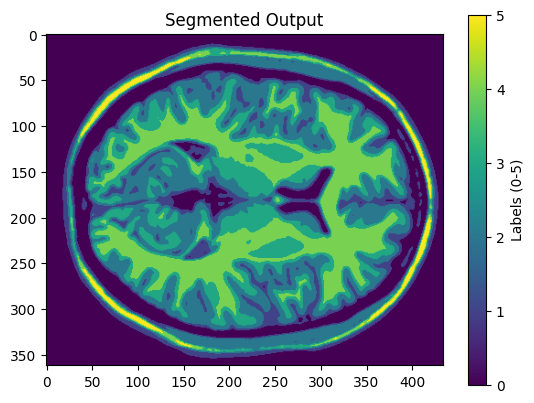

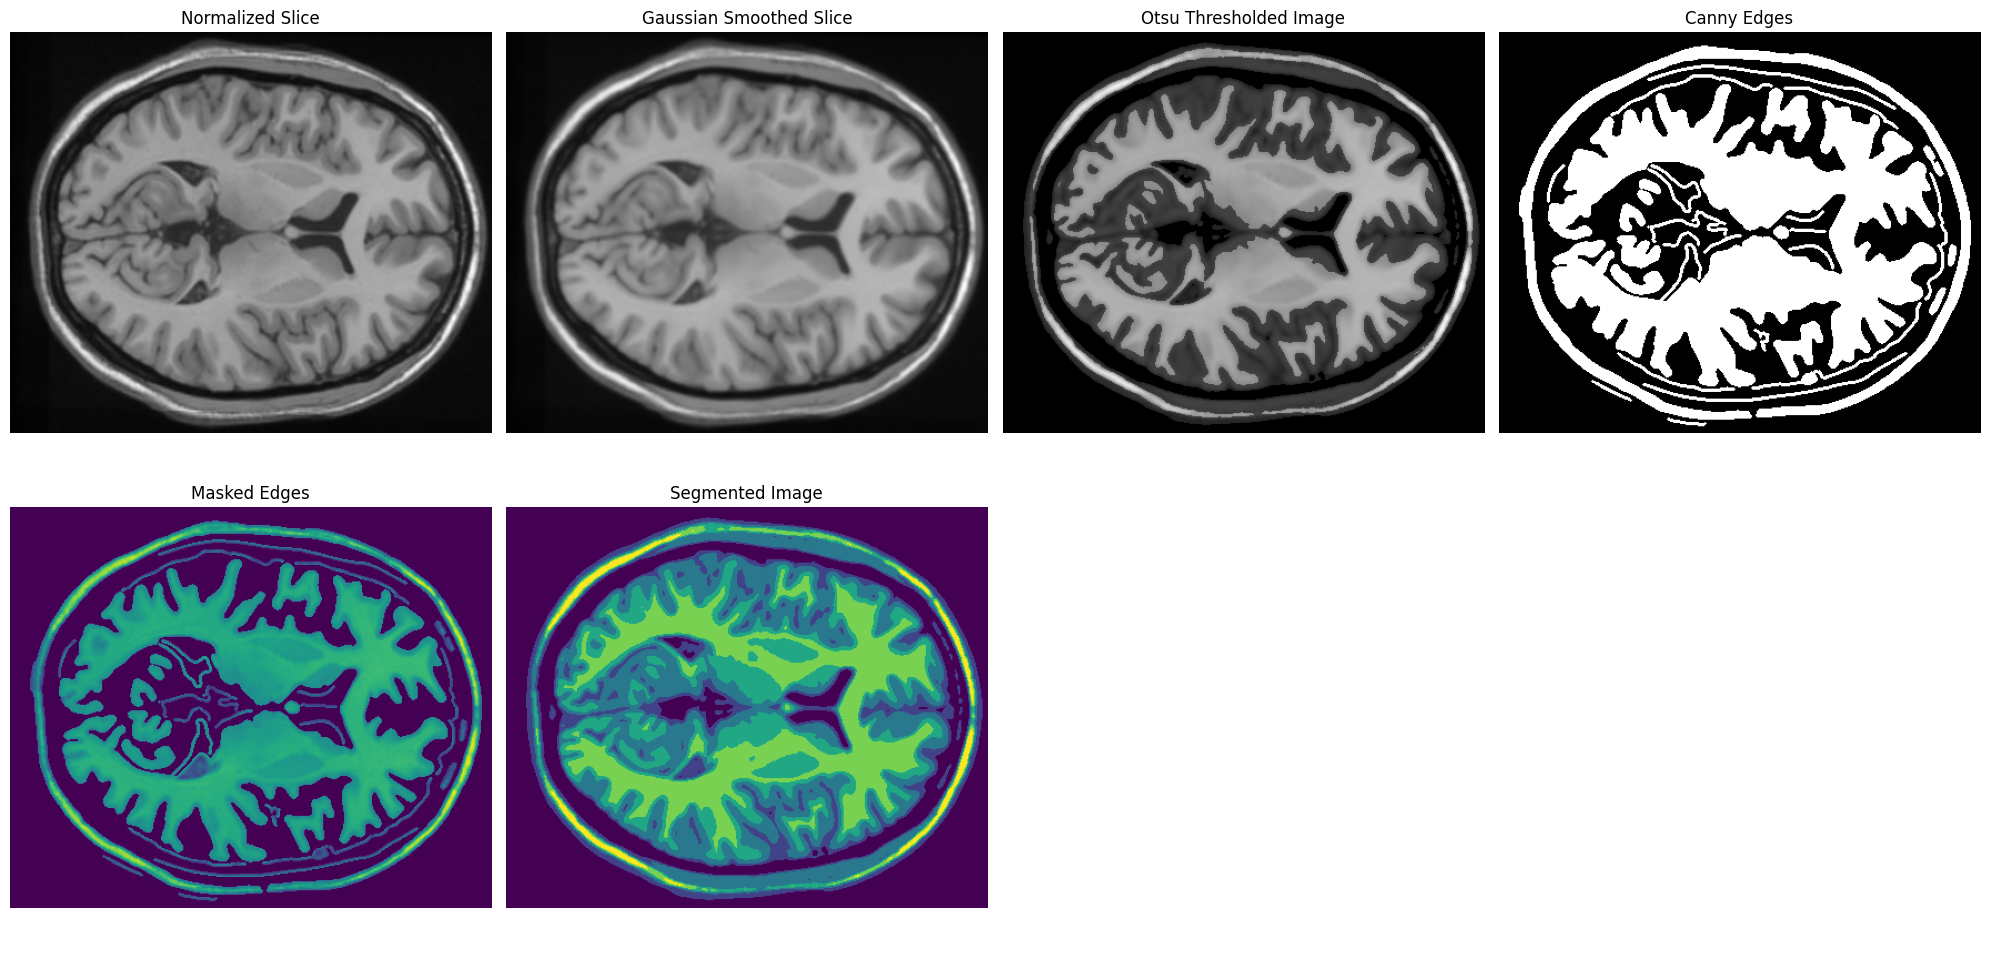

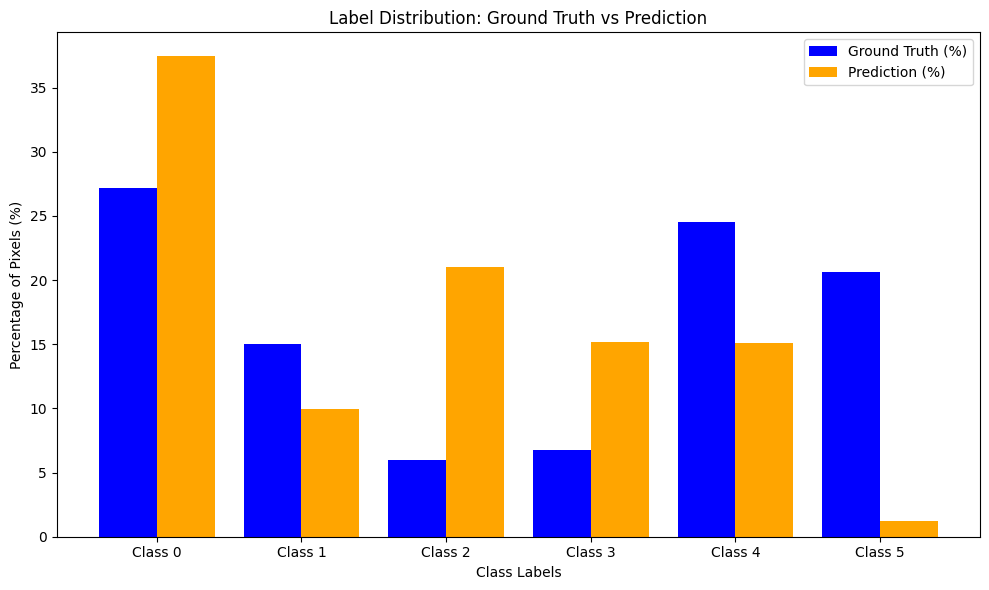

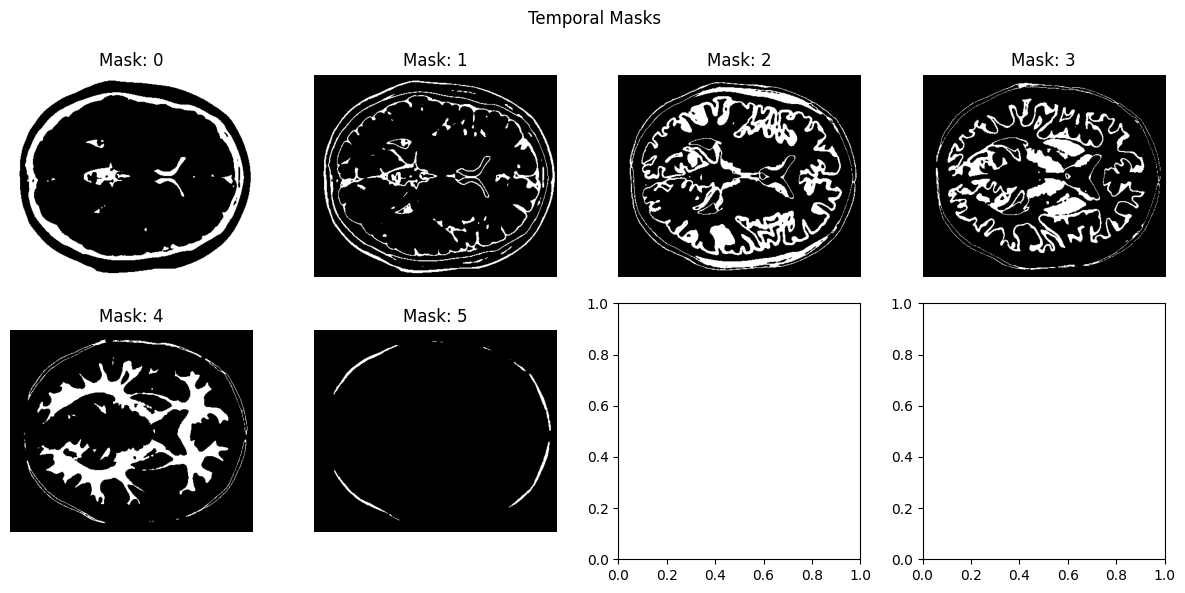

In [36]:
#Showcasing results
slice = T1

#Metrics
print("-------------- Metrics -----------------")
print(f"Dice Coefficient: {dice_score:.3f}")
print(f"Jaccard Index: {jaccard_score:.3f}")
print(f"Pixel Accuracy: {accuracy_score:.3f}")
print("----------------------------------------")

#Showcasing segmented image
plt.imshow(segmented_img[:, :, segmented_img.shape[2] // 2])
plt.title('Segmented Output')
plt.colorbar(ticks=range(6), label="Labels (0-5)")
plt.show()

#Showcaisng all segmentation steps taken
temporal_masks, segmented_img, dice_score, jaccard_score, accuracy_score = full_segmentation(slice)

#Showcasing the temporal masks used to hold the model labels
plot_masks(temporal_masks, rows=2, cols=4)

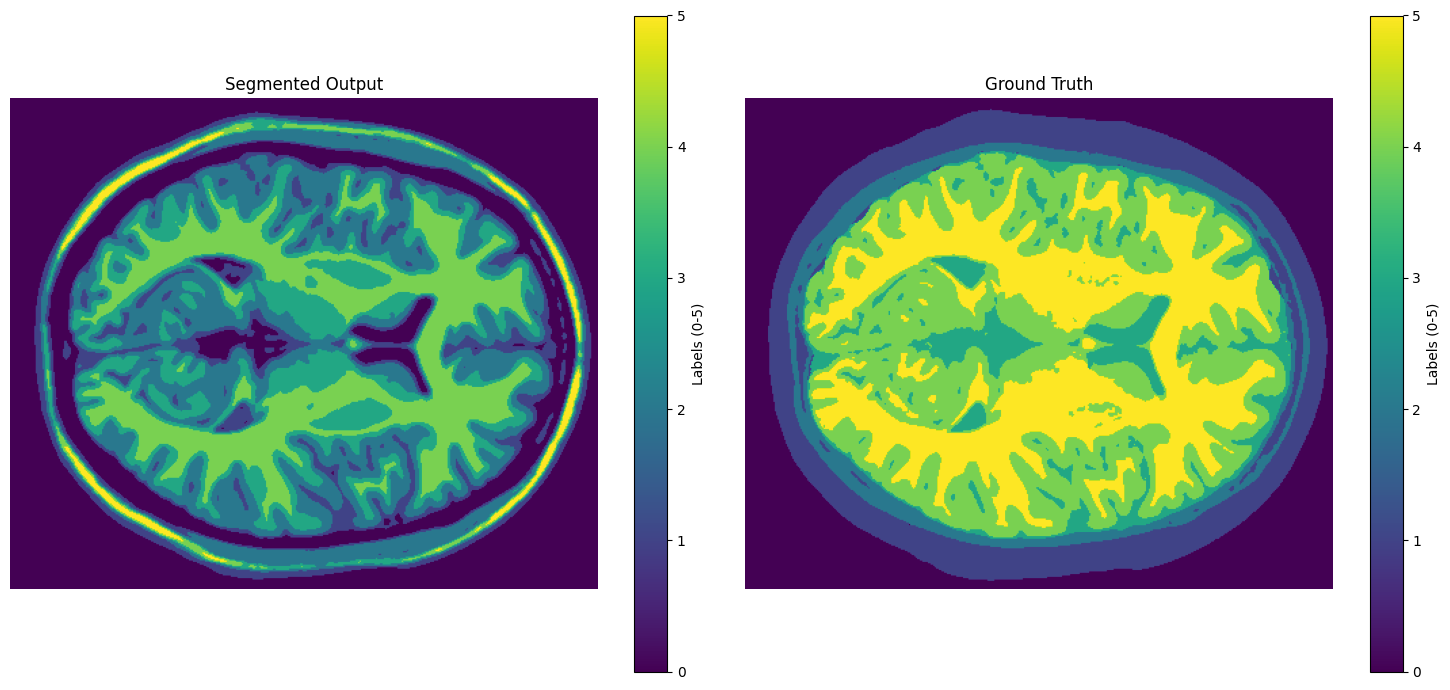

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Segmented Image
im = axes[0].imshow(segmented_img[:, :, segmented_img.shape[2] // 2], cmap='viridis') # Assign the output of imshow to a variable
axes[0].set_title('Segmented Output')
axes[0].axis('off')
fig.colorbar(im, ax=axes[0], orientation='vertical', label="Labels (0-5)") # Use fig.colorbar and pass the image object

# Ground Truth
im2 = axes[1].imshow(label[:, :, label.shape[2] // 2], cmap='viridis') # Assign the output of imshow to a variable
axes[1].set_title('Ground Truth')
axes[1].axis('off')
fig.colorbar(im2, ax=axes[1], orientation='vertical', label="Labels (0-5)") # Use fig.colorbar and pass the image object

plt.tight_layout()
plt.show()
